# Quickstart

With `GaiaAlertsPy` installed, you can easily extract each detection from the Gaia alerts.

In [4]:
import sys 
import os
sys.path.append(os.path.abspath("/Users/andytzanidakis/Desktop/desk/astro_research/open_source_tools/GaiaAlertsPy/"))

%load_ext autoreload
%autoreload 2

In [5]:
from GaiaAlertsPy import alert as gaap
from GaiaAlertsPy import bprpspec
from matplotlib import rcParams
import numpy as np 

# fancy plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

For example, let’s download and display the light curve for a specific alert, identified as Gaia20dvt. First, start Python and use the GaiaAlert class to obtain the light curve data for the alert from the data archive:

In [105]:
target_id = "Gaia18cfo" 
alert_lc = gaap.GaiaAlert(target_id).query_lightcurve_alert()

In [106]:
# Now we can even query the BP_RP information
color_lc = gaap.GaiaAlert(target_id).query_bprp_history()

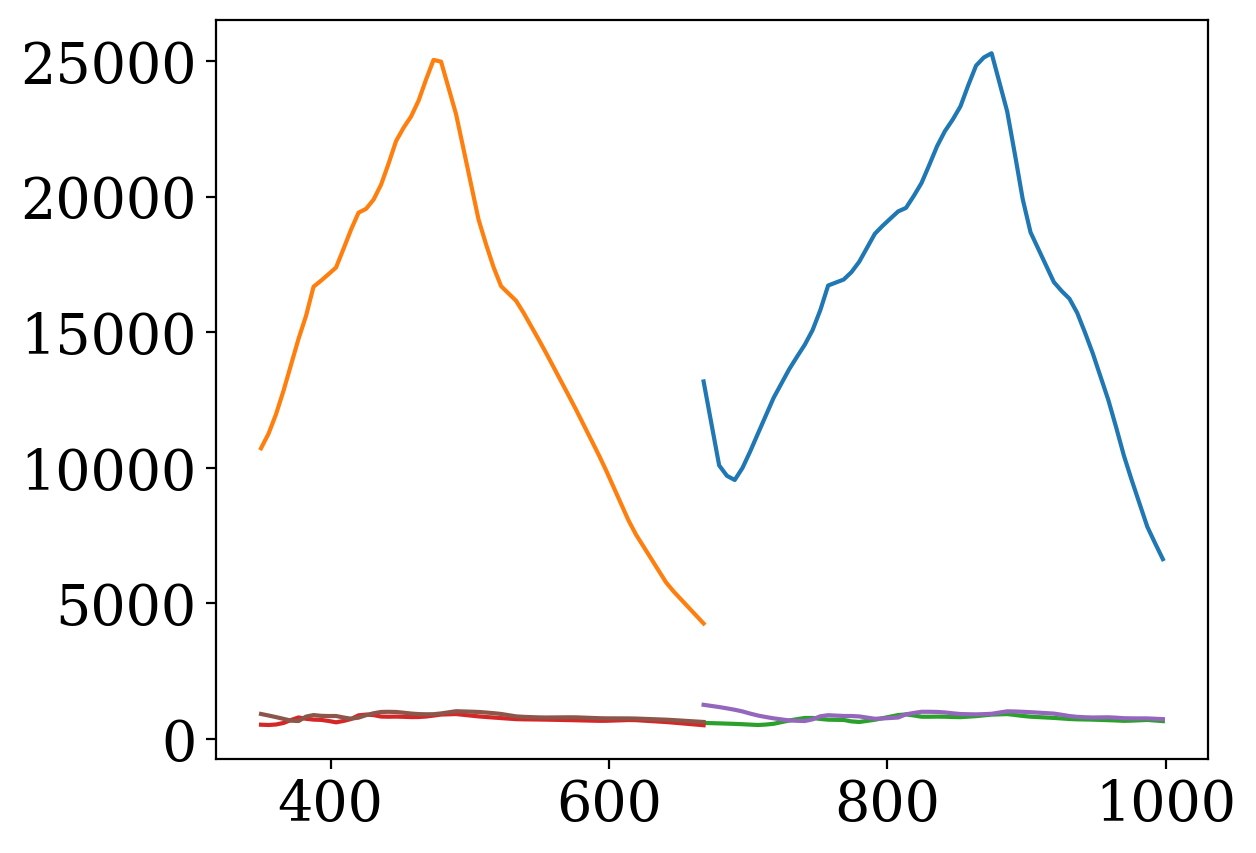

In [152]:
for i in range(0, 3):
    sbp, srp = color_lc[i]['bp'], color_lc[i]['rp']
    j = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='rp')
    jj = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='bp')
    jjj = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='both')

    plt.plot(j[0], j[1]+5*i)
    plt.plot(jj[0], jj[1]+5*i)
    #plt.plot(jjj[0], jjj[1]+5*i)




In [153]:
import numpy as np

In [154]:
sbp, srp = color_lc[i]['bp'], color_lc[i]['rp']
j = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='rp')
jj = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='bp')
jjj = bprpspec.XPStitch(sbp, srp).stitch_spectra(mode='both')

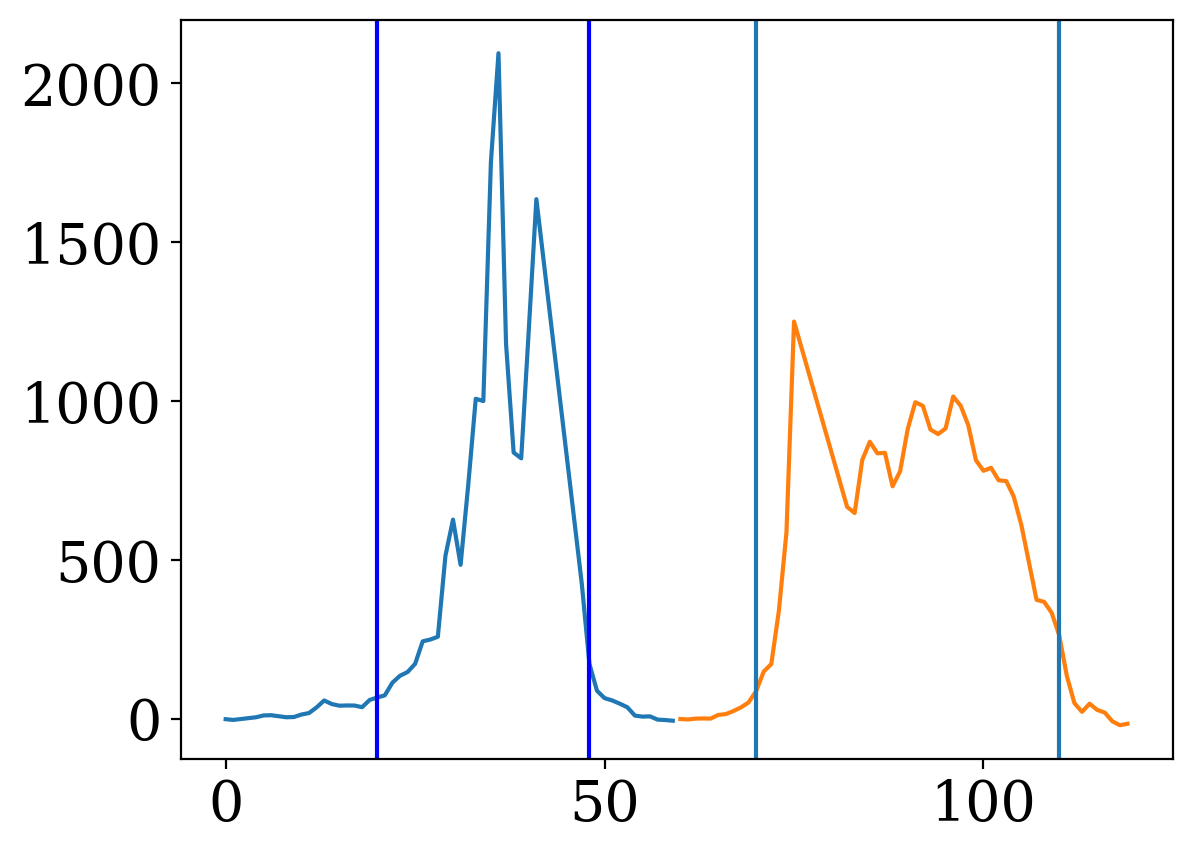

In [155]:
plt.plot(range(0, 60), sbp)
plt.plot(range(60, 120), srp)
plt.axvline(20, color='blue')
plt.axvline(48, color='blue')
plt.axvline(70)
plt.axvline(110)

## Pseudo-Wavelength Pixel Calibration

In [87]:
import pandas as pd
tbl = pd.read_csv("nominalXpSamplePositions_colsSimple_PUBISHED.csv")

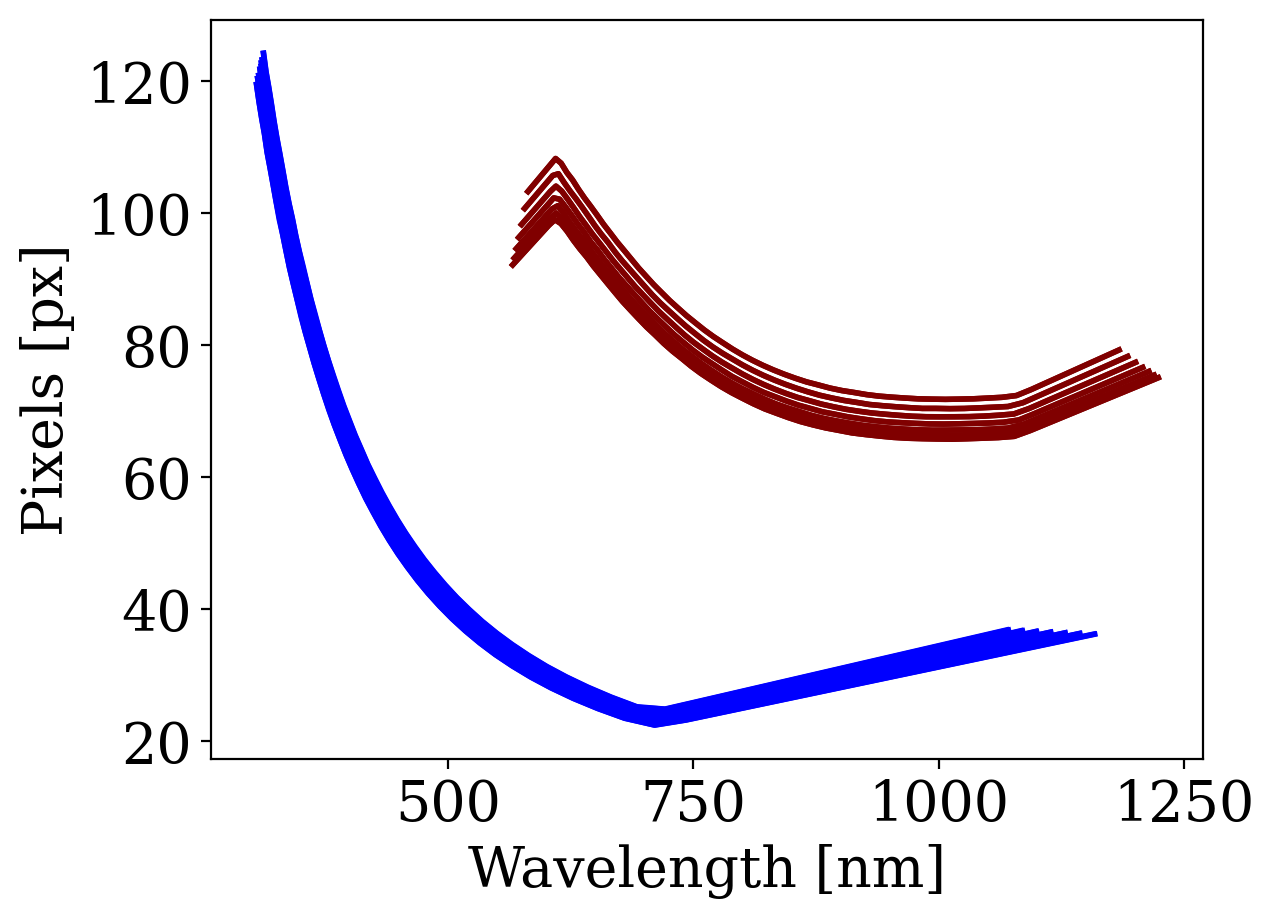

In [173]:
xdat, ydat = [], []

for j in range(1,3):
    for i in range(1, 8):
        xdat.append(tbl[f'RP_ROW{i}_FOV{j}_wavelength_nm'].values)
        ydat.append(1/(tbl[f'RP_ROW{i}_FOV{j}_sampling_nm/pix'].values * 1/tbl[f'RP_ROW{i}_FOV{j}_wavelength_nm'].values))
        
        plt.plot(tbl[f'BP_ROW{i}_FOV{j}_wavelength_nm'],
                  1/(tbl[f'BP_ROW{i}_FOV{j}_sampling_nm/pix'] * 1/tbl[f'BP_ROW{i}_FOV{j}_wavelength_nm']), lw=2, 
                  ls='-', 
                  color='blue')
        
        plt.plot(tbl[f'RP_ROW{i}_FOV{j}_wavelength_nm'],
                 1/(tbl[f'RP_ROW{i}_FOV1_sampling_nm/pix'] * 1/tbl[f'RP_ROW{i}_FOV{j}_wavelength_nm']), lw=2, 
                  ls='-', 
                  color='maroon')

    plt.xlabel("Wavelength [nm]")
    plt.ylabel("Pixels [px]")

In [168]:
xdat, ydat = np.concatenate(xdat), np.concatenate(ydat)
xs = np.argsort(xdat)
xdat, ydat = xdat[xs], ydat[xs]

# cut the data
cut = np.where((xdat>629) & (xdat<919))

xdat, ydat = xdat[cut], ydat[cut]

# Add a little uncertainty to it
ydat += np.random.normal(0, 3, size=len(ydat))

In [169]:
# define a 6th degree polynomial
def poly5d(x, a, b, c, d, e, f, g):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5 + g*x**6

from scipy.optimize import curve_fit

popt, _ = curve_fit(poly5d, xdat, ydat)


In [170]:
print (f"polynomial params: {popt}")

polynomial params: [ 3.24106221e+04 -2.54215293e+02  8.35868766e-01 -1.46627046e-03
  1.44434907e-06 -7.56656062e-10  1.64591570e-13]


In [171]:
popt

array([ 3.24106221e+04, -2.54215293e+02,  8.35868766e-01, -1.46627046e-03,
        1.44434907e-06, -7.56656062e-10,  1.64591570e-13])

Text(0.5, 1.0, 'RP Calibration')

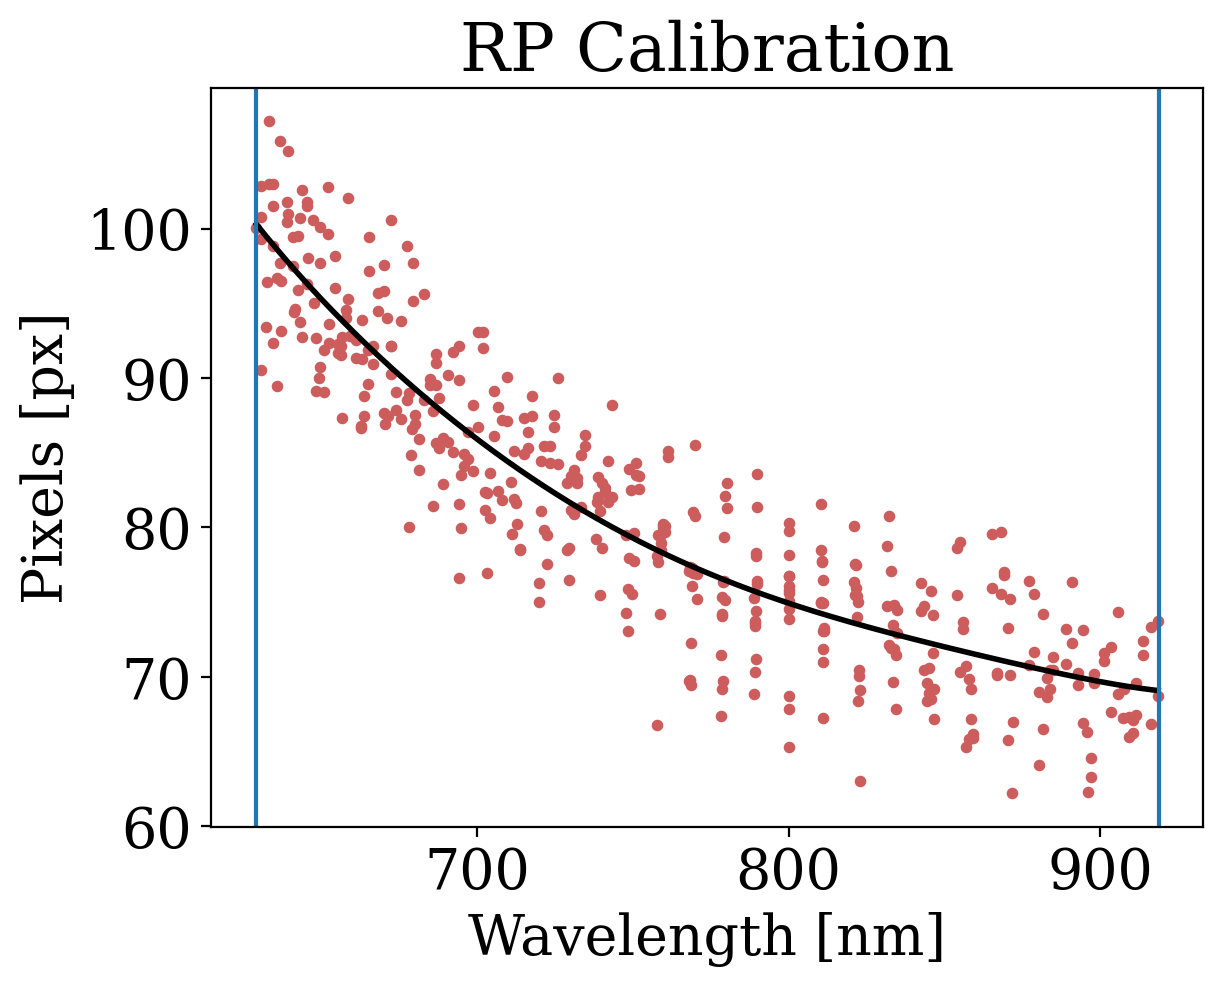

In [172]:
plt.figure()

plt.scatter(xdat, ydat, color='indianred', s=10)
xlin = np.linspace(min(xdat), max(xdat), 1000)

plt.plot(xlin, poly5d(xlin, *popt), lw=2, color='black')
plt.xlabel("Wavelength [nm]")
plt.ylabel("Pixels [px]")

plt.axvline(629)
plt.axvline(919)

plt.title("RP Calibration")

Text(0.5, 1.0, 'BP Calibration')

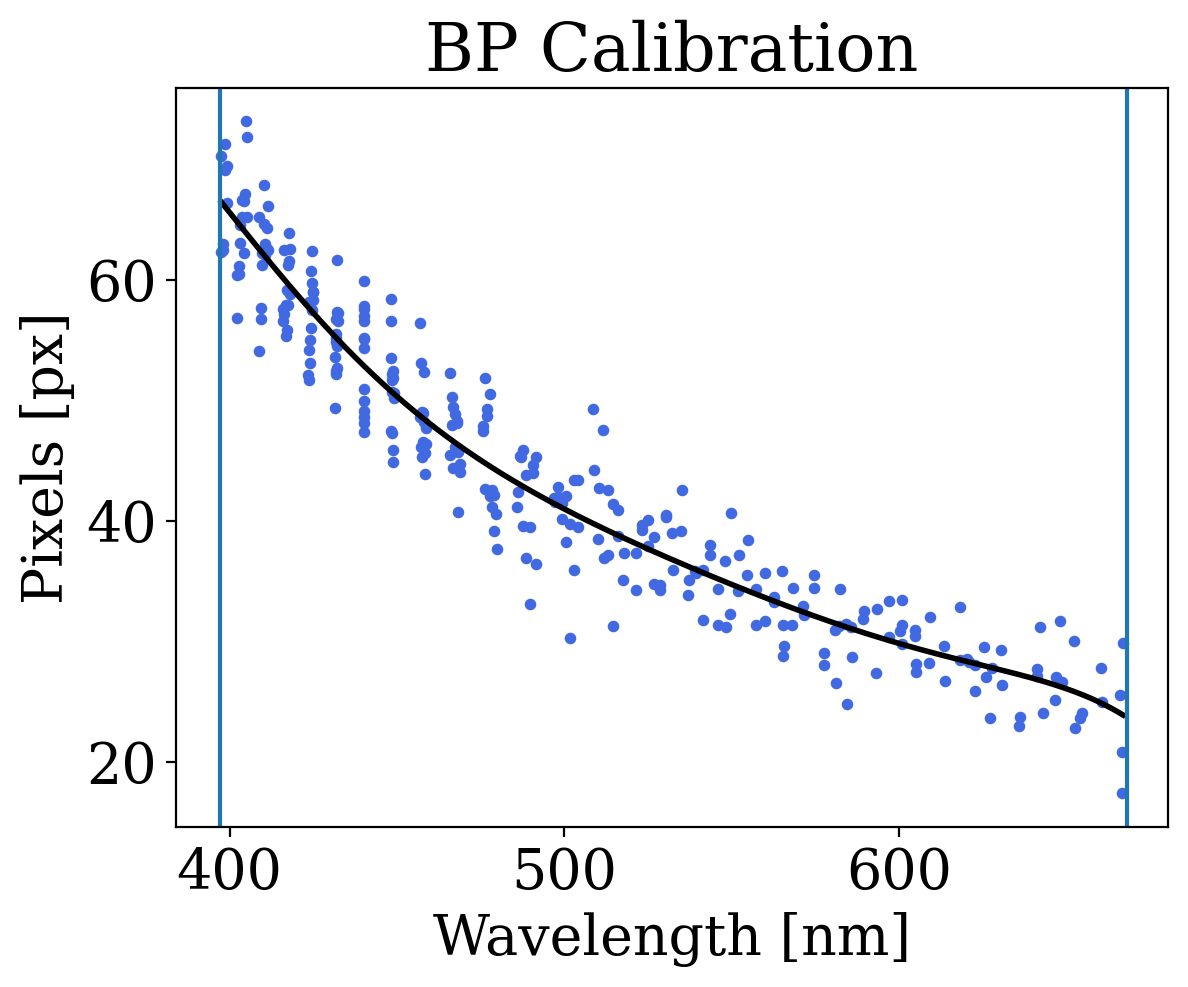

In [63]:
plt.figure()

plt.scatter(xdat, ydat, color='RoyalBlue', s=10)
xlin = np.linspace(min(xdat), max(xdat), 1000)

plt.plot(xlin, poly5d(xlin, *popt), lw=2, color='black')
plt.xlabel("Wavelength [nm]")
plt.ylabel("Pixels [px]")

plt.axvline(668)
plt.axvline(397)

plt.title("BP Calibration")

In [174]:
def bp_polynomial_pixels(w):
    """Given wavelength w (in nm) this function will return the pixel position"""
    theta = [-2.01060252e+04,  2.42020532e+02, -1.19202924e+00,  3.09444798e-03,
       -4.47630437e-06,  3.42566361e-09, -1.08447529e-12]
    
    return poly5d(w, *theta)


# Want to write a function that takes the pixels and returns the closest wavelength
def bp_pixel_wavelength(pixel):
    """Given a pixel position, this function will return the closest wavelength"""
    
    j = np.linspace(397, 668, 5000)
    pixels = bp_polynomial_pixels(j)
    
    res = np.abs(pixels - pixel)
    return j[np.argmin(res)]

def rp_polynomial_pixels(w):
    theta = [5.98535486e+04, -4.72182213e+02,  1.55084315e+00, -2.70723484e-03,
        2.64759237e-06, -1.37522490e-09,  2.96444540e-13]
    
    return poly5d(w, *theta)

# Want to write a function that takes the pixels and returns the closest wavelength
def rp_pixel_wavelength(pixel):
    """Given a pixel position, this function will return the closest wavelength"""
    
    j = np.linspace(629, 919, 5000)[::-1]
    pixels = rp_polynomial_pixels(j)
    
    res = np.abs(pixels - pixel)
    return j[np.argmin(res)]

    
def _cal(P, mode='bp'):
    match = []
    
    for p in P:
        if mode=='bp':
            match.append(bp_pixel_wavelength(p))
        elif mode=='rp':
            match.append(rp_pixel_wavelength(p))

    return np.array(match)


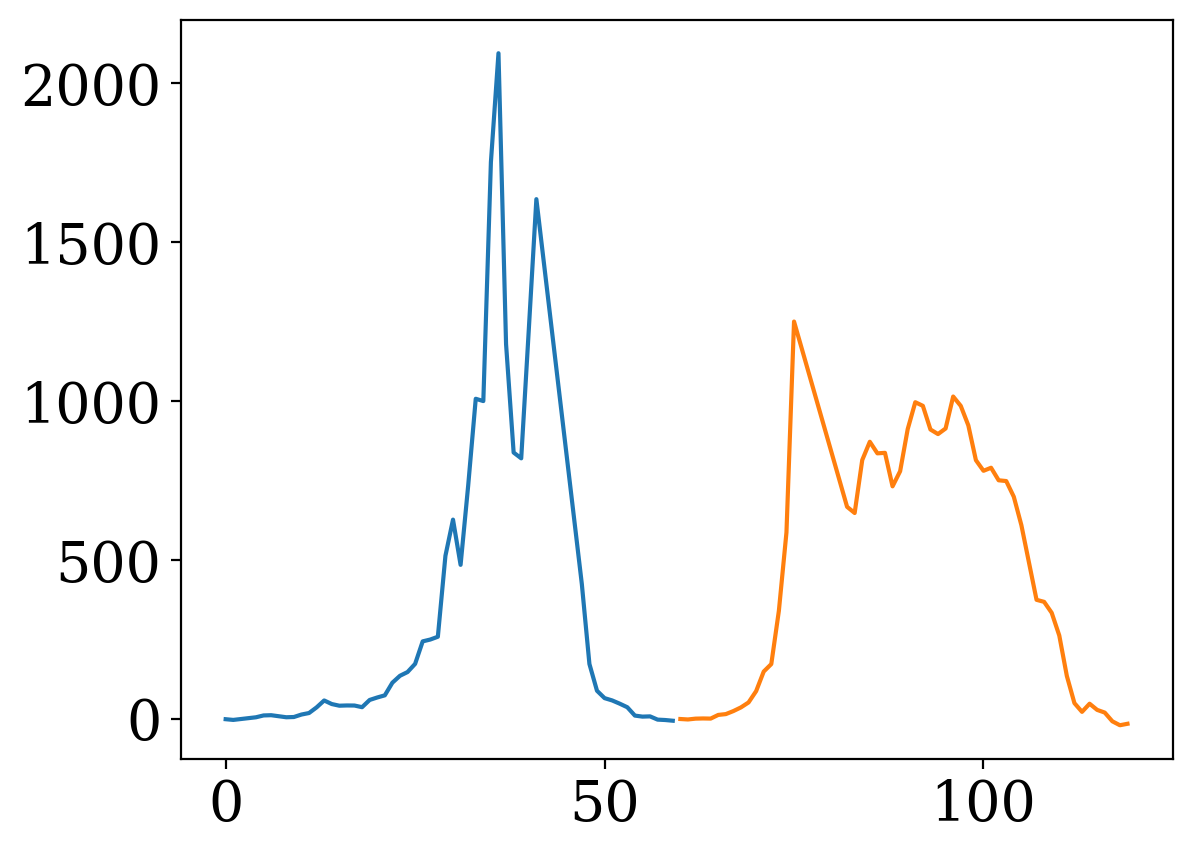

In [175]:
plt.plot(range(0, 60), sbp)
plt.plot(range(60, 120), srp)

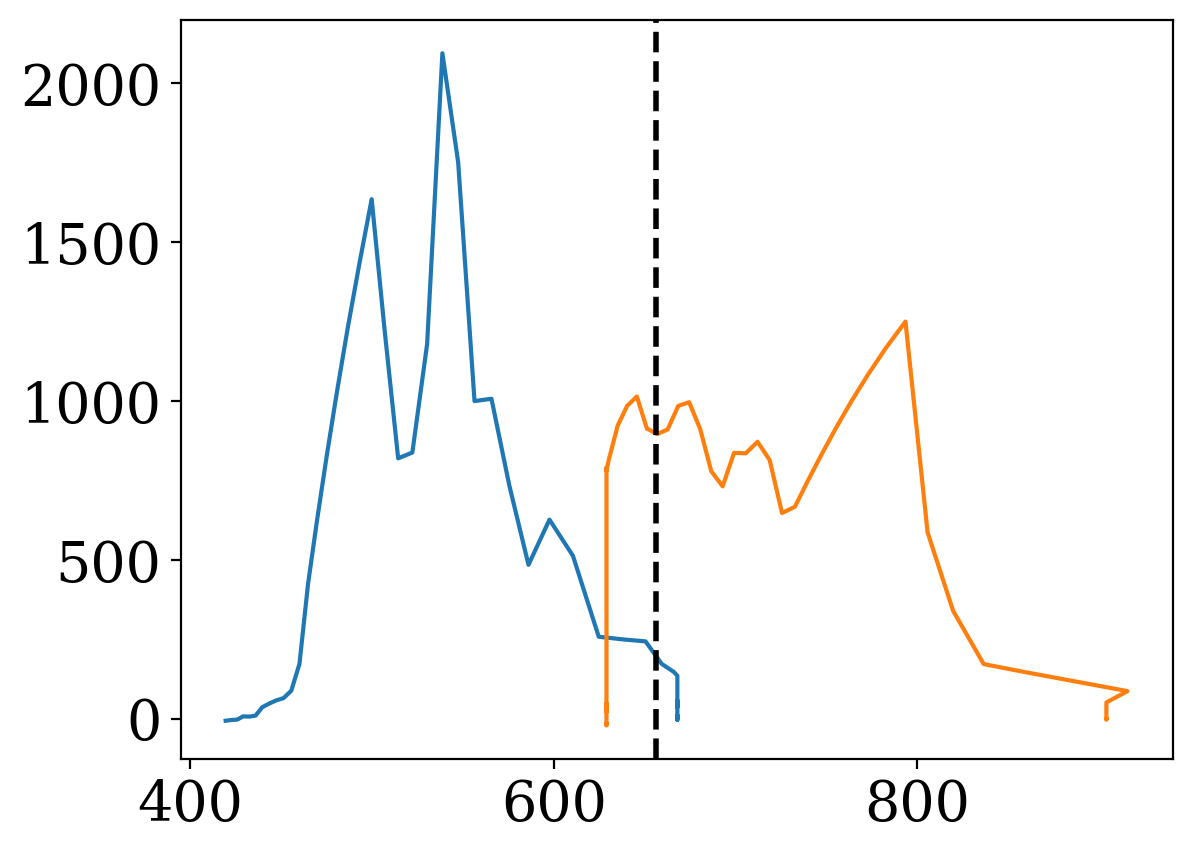

In [176]:
plt.plot(_cal(np.arange(0, 60, step=1), mode='bp'), sbp)
plt.plot(_cal(range(60, 120), mode='rp'), srp)

plt.axvline(656.2, color='k', lw=2, ls='--')

In [208]:
# lead read the table from this page
from astropy.io import ascii
ascii.read("https://gsaweb.ast.cam.ac.uk/alerts/gaiax/2023")

Run,Earliest,Latest,No. of Alerts,Published,CSV
int64,str19,str19,int64,str19,str14
7470,2023-12-28T23:32:13,2023-12-30T07:25:11,123,2023-12-31T17:10:03,gaiax_7470.csv
7469,2023-12-27T19:10:56,2023-12-29T08:56:45,159,2023-12-31T09:50:03,gaiax_7469.csv
7468,2023-12-26T20:28:36,2023-12-28T10:28:05,121,2023-12-29T09:40:03,gaiax_7468.csv
7467,2023-12-25T09:21:04,2023-12-27T10:19:27,119,2023-12-28T09:50:03,gaiax_7467.csv
7465,2023-12-25T04:55:03,2023-12-26T12:41:48,111,2023-12-27T15:30:03,gaiax_7465.csv
7464,2023-12-24T16:44:30,2023-12-25T16:28:32,88,2023-12-27T09:10:03,gaiax_7464.csv
7463,2023-12-23T18:44:52,2023-12-24T19:33:07,109,2023-12-26T10:30:04,gaiax_7463.csv
7462,2023-12-22T19:59:12,2023-12-23T22:29:10,130,2023-12-25T12:00:03,gaiax_7462.csv
7461,2023-12-21T23:13:44,2023-12-23T01:54:05,132,2023-12-24T13:40:03,gaiax_7461.csv


In [211]:
class GaiaX:
    def GaiaX_history(self, year='2021'):
        """Return astropy.Table of all GaiaX Alerts to-date.

        Parameters:
        ----------
            year (int): year.

        Returns:
            astropy.Table: all GaiaX Alerts to-date
        """
        base_table_url = "https://gsaweb.ast.cam.ac.uk/alerts/gaiax"

        return ascii.read(f"{base_table_url}/{year}")   


    def GaiaX_alert(self, alert_id):
        base_table_url = "https://gsaweb.ast.cam.ac.uk/alerts/gaiax/"
        return ascii.read(f"{base_table_url}/{alert_id}")

In [212]:
GaiaX().GaiaX_history(year='2023')

Run,Earliest,Latest,No. of Alerts,Published,CSV
int64,str19,str19,int64,str19,str14
7470,2023-12-28T23:32:13,2023-12-30T07:25:11,123,2023-12-31T17:10:03,gaiax_7470.csv
7469,2023-12-27T19:10:56,2023-12-29T08:56:45,159,2023-12-31T09:50:03,gaiax_7469.csv
7468,2023-12-26T20:28:36,2023-12-28T10:28:05,121,2023-12-29T09:40:03,gaiax_7468.csv
7467,2023-12-25T09:21:04,2023-12-27T10:19:27,119,2023-12-28T09:50:03,gaiax_7467.csv
7465,2023-12-25T04:55:03,2023-12-26T12:41:48,111,2023-12-27T15:30:03,gaiax_7465.csv
7464,2023-12-24T16:44:30,2023-12-25T16:28:32,88,2023-12-27T09:10:03,gaiax_7464.csv
7463,2023-12-23T18:44:52,2023-12-24T19:33:07,109,2023-12-26T10:30:04,gaiax_7463.csv
7462,2023-12-22T19:59:12,2023-12-23T22:29:10,130,2023-12-25T12:00:03,gaiax_7462.csv
7461,2023-12-21T23:13:44,2023-12-23T01:54:05,132,2023-12-24T13:40:03,gaiax_7461.csv


In [184]:
tbl = ascii.read("https://gsaweb.ast.cam.ac.uk/alerts/gaiax/gaiax_8147.csv")

In [190]:
tbl = ascii.read("https://gsaweb.ast.cam.ac.uk/alerts/gaiax/2021")

(array([129., 307., 204.,  49.,   7.,   7.,   3.,   1.,   1.,   2.]),
 array([   7. ,  109.2,  211.4,  313.6,  415.8,  518. ,  620.2,  722.4,
         824.6,  926.8, 1029. ]),
 <BarContainer object of 10 artists>)

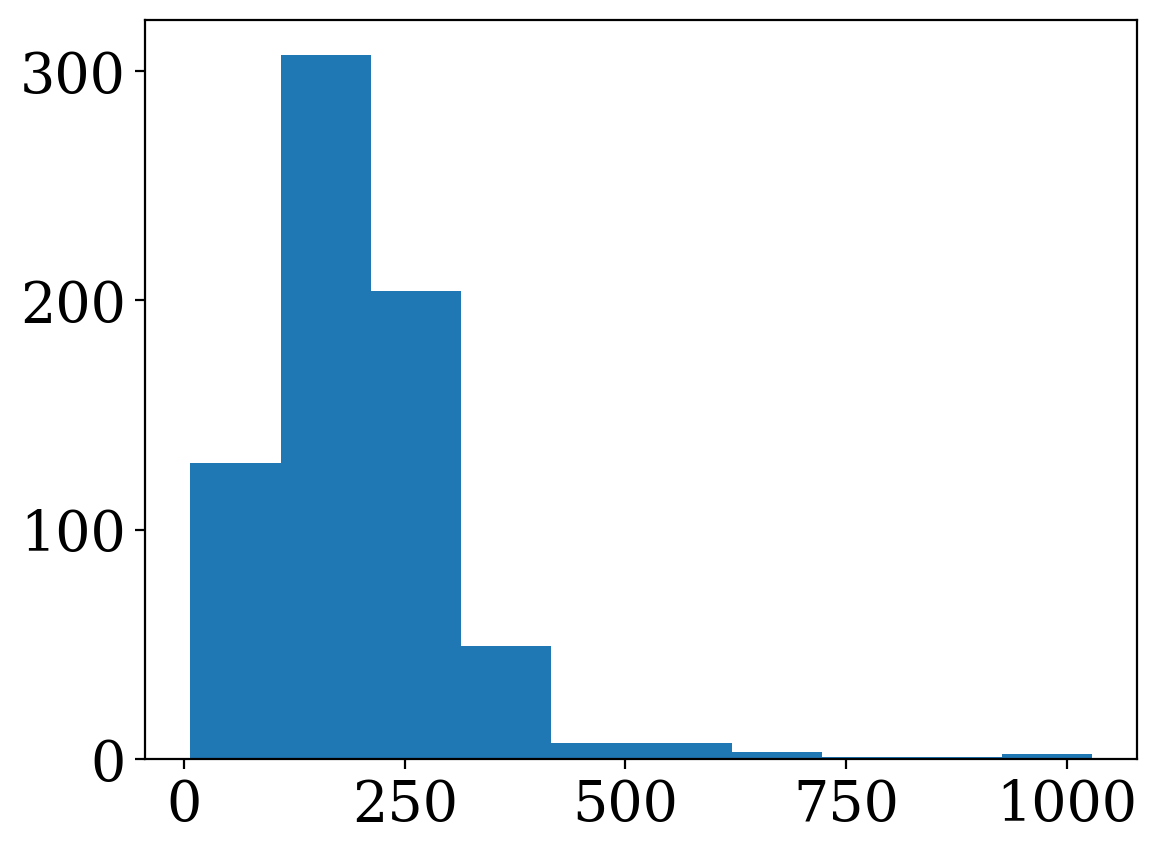

In [197]:
plt.hist(tbl['No. of Alerts'])

In [48]:
rp_polynomial_pixels(700)

86.87566046007123

In [50]:
rp_pixel_wavelength(60 + 1)

904.120824164833

In [106]:
bp_pixel_wavelength(60)

416.2324649298597

In [ ]:
rp_pixel_wavelength(25)

894.5891783567134

In [329]:
bp_pixel_wavelength([50, 60])

array([452.2295223 , 415.05915059])

In [331]:
bp_polynomial_pixels(452.2295223), bp_polynomial_pixels(415.05915059)

(49.999626166886955, 60.00203090640153)

In [291]:
bp_polynomial_pixels(600)

29.680925093121743